In [2]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

sys.path.append("../response/")
from feature import Feature

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
error_types = ['Unclear intention', 'Wrong information',
 'Ignore question', 'Topic transition error', 
 'Lack of information', 'Repetition', 
 'Contradiction', 'Self-contradiction',
  'Lack of common sense', 'Semantic error',
   'Grammatical error', 'Ignore proposal', 
   'Ignore offer', 'Lack of sociality', 
   'Uninterpretable', 'Ignore greeting', 
   'No-Err']


In [4]:
convs = read_conv(path, datalist)

In [5]:
F1_path = "../X_y_data/response/"
F1_name = "forback1.pickle"
featureM1 = DataManager(F1_path)

F_fb = featureM1.load_data(F1_name)
F_fb.set_preprocessor(Preprocessor())

success load : ../X_y_data/response/forback1.pickle
300


In [6]:
from sklearn.ensemble import AdaBoostClassifier
model1_path = "../models/response/"
model1_name = "forback_clf.pickle"
modelM1 = DataManager(model1_path)

clf_fb = modelM1.load_data(model1_name)

success load : ../models/response/forback_clf.pickle


In [207]:
from pyknp import Juman
from sentence_transformers import SentenceTransformer
import scipy.spatial
model_path = "/home/yamada/Downloads/training_bert_japanese"
Nmodel = SentenceTransformer(model_path, show_progress_bar=False)
emb_dim = Nmodel.encode(["お辞儀をしている男性会社員"])[0].shape[0]

In [208]:
# 残す形態素
pos_sets = set("名詞 代名詞 動詞 形容詞 接続詞 連体詞".split() )
def utt2vecter_s(ut):
    vector = np.zeros(300)
    remains = 0
    for token in nlp(ut.utt):
        tag = token.tag_.split("-")[0]
        if tag in pos_sets:
            vector += token.vector
            remains += 1
    
    if remains < 2:
        return vector
    else:
        return vector/remains

In [209]:
def utt2vecter_BERT(ut):
    return Nmodel.encode(ut.utt)[0]

In [210]:
from tqdm import tqdm
def make_X_diff(convs, errors:list,  dim=300):
    X = []
    y = []
    for conv in tqdm(convs):
        # X_ = [ np.zeros(2*dim+2) for _ in range(length-1) ] 
        # X_ = [ np.zeros(dim+2) for _ in range(length-1) ] 
        # prev_vector = np.zeros( dim )
        for i, ut in enumerate(conv):
            # print(i)
            if i==0:
                continue
            if not ut.is_system() or ut.is_utt_level_error():
                continue
            # fb
            # 0: 後ろ向き   1: 前向き
            # f = F_fb.featurization(ut.utt)
            # f2 = F_fb.featurization(conv[i-1].utt)
            # fb_proba = clf_fb.predict(f.reshape(1, -1))
            # fb2 = clf_fb.predict(f2.reshape(1, -1))
            f = [ F_fb.featurization(s) for s in [conv[i-1].utt, ut.utt] ]
            fb = clf_fb.predict(f)
            fb_ = np.zeros(4)
            for j, p in enumerate(fb):
                fb_[2*j+int(p)] = 1
            # print(i, fb, conv[i-1], ut.utt)
            # vector = utt2vecter_mini(ut, dim)
            if dim==768:
                vector = utt2vecter_BERT(conv[i-1]) - utt2vecter_BERT(ut)
            else:
                vector = utt2vecter_s(conv[i-1]) - utt2vecter_s(ut)
            # prev_vector = vector
            x_cat_vector = np.concatenate( [fb_, vector] )
            # X_.append( x_cat_vector )
            X.append(x_cat_vector)
            
            y.append(1 if ut.is_error_included(errors) else 0)
        # break
    return np.array(X), np.array(y)

In [211]:
errors = ["Topic transition error", "Unclear intention", "Lack of information"]
X, y = make_X_diff(convs, errors, dim=768)

  0%|          | 1/200 [00:03<11:08,  3.36s/it]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f1644cce748>>
Traceback (most recent call last):
  File "/home/yamada/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/yamada/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
100%|██████████| 200/200 [12:20<00:00,  3.70s/it]


In [257]:
data_path = "../X_y_data/context/"
data_name = "topic_proposal_bert.pickle"
dataM = DataManager(data_path)
dataM.save_data(data_name, [X, y])

success save : ../X_y_data/context/topic_proposal_bert.pickle


In [258]:
if dataM.is_exist(data_name):
    DATA_Xy = dataM.load_data(data_name)
    X = DATA_Xy[0]
    y = DATA_Xy[1]
else:
    dataM.save_data(data_name, [X, y])

success load : ../X_y_data/context/topic_proposal_bert.pickle


In [309]:
y = []
errors = ["Topic transition error", "Unclear intention", "Lack of information"]
errors = errors[:1]
for conv in tqdm(convs):
    for i, ut in enumerate(conv):
        if i==0:
                continue
        if not ut.is_system() or ut.is_utt_level_error():
                continue
        y.append(1 if ut.is_error_included(errors) else 0)

100%|██████████| 200/200 [00:00<00:00, 103473.64it/s]


In [310]:
np.count_nonzero(y)

192

In [238]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

In [327]:
class TopicModel(nn.Module):
    def __init__(self, embedding_dim, tagset_size, batch_size):
        # 親クラスのコンストラクタ。決まり文句
        super(TopicModel, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hid1= embedding_dim*2
        self.hid2 = embedding_dim//2
        self.fb_dim = 4
        # self.fb_dim = 0
        self.fc1 = nn.Linear(self.embedding_dim, self.hid1)
        self.fc2 = nn.Linear(self.hid1, self.hid2)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        # self.hidden2tag = nn.Linear(self.hid2+self.fb_dim, tagset_size)
        self.hidden2tag = nn.Linear(self.hid2, tagset_size)
    
    def forward(self, x):
        fb = x[:, :self.fb_dim]
        # print(x.shape, fb.shape)
        y = F.relu(self.fc1(x[:, self.fb_dim:]))
        # y = F.relu(self.fc1(x[]))
        y = F.relu(self.fc2(y))
        # print(x.shape, torch.cat( (y, fb), 1 ).shape)
        # y = self.hidden2tag( torch.cat( (y, fb), 1 ) )
        y = self.hidden2tag( y )
        y = F.log_softmax(y, dim=1)
        return y

In [328]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [330]:
X_train = X_train[:-1]
y_train = y_train[:-1]
leng = len(y_train)
print(leng)
for i, v in enumerate(y_train):
    if leng %(i+1) == 0:
        print(i+1, end=", ")

1290
1, 2, 3, 5, 6, 10, 15, 30, 43, 86, 129, 215, 258, 430, 645, 1290, 

In [331]:
BATCH_SIZE = 129
epoch_ = 800
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [332]:
EMBEDDING_DIM = emb_dim
# EMBEDDING_DIM = 300
OUTPUT_DIM = 2

In [333]:
X.shape

(1614, 772)

In [334]:
model = TopicModel(EMBEDDING_DIM, OUTPUT_DIM, BATCH_SIZE)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [335]:
losses = []
loss_border = 0.0001
# print("error[{0}]".format(error_types[error_i]))
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        X_t_tensor = torch.tensor(data[0], device='cuda:0').float()
        # y_t_tensor = torch.tensor(data[1].reshape(batch_size, 1), device='cuda:0').float()
        y_t_tensor = torch.tensor(data[1], device='cuda:0').long()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)
        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
    # if all_loss <= loss_border:
    #     print("loss was under border(={0}) : train end".format(loss_border))
    #     break
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


epoch 50 	 loss 3.1916584968566895
epoch 100 	 loss 2.0309180468320847
epoch 150 	 loss 1.0906330347061157
epoch 200 	 loss 0.7148786447942257
epoch 250 	 loss 0.5743600316345692
epoch 300 	 loss 0.5197888687252998
epoch 350 	 loss 0.494805708527565
epoch 400 	 loss 0.48041120544075966
epoch 450 	 loss 0.4772825539112091
epoch 500 	 loss 0.4708304591476917
epoch 550 	 loss 0.4693285981193185
epoch 600 	 loss 0.46872336231172085
epoch 650 	 loss 0.4638027437031269
epoch 700 	 loss 0.465950820595026
epoch 750 	 loss 0.4692418519407511
epoch 800 	 loss 0.46886991895735264
done


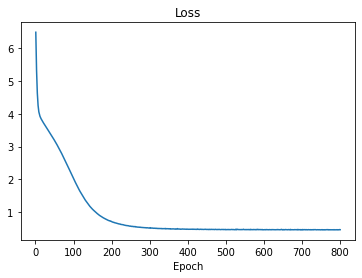

In [336]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [337]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

In [338]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[267  12]
 [ 38   6]]
accuracy =  0.8452012383900929
precision =  0.3333333333333333
recall =  0.13636363636363635
f1 score =  0.1935483870967742


In [339]:
np.count_nonzero(y)

192

In [340]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)

AdaBoostClassifier()

In [341]:
y_pred = clf.predict(X_test)

In [342]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[262  17]
 [ 36   8]]
accuracy =  0.8359133126934984
precision =  0.32
recall =  0.18181818181818182
f1 score =  0.2318840579710145


In [343]:
X.shape

(1614, 772)

In [344]:
np.count_nonzero(y)

192